In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
from torchvision import transforms as T
import torch

from grconvnet.dataloading import CornellDataset
from grconvnet.preprocessing import Preprocessor, Masker
from grconvnet.postprocessing import Postprocessor, SkGaussian, Scaler, GraspLocalizer
from grconvnet.models import GenerativeResnet
from grconvnet.utils import visualization as vis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = CornellDataset(
    Path("/home/moritz/Documents/cornell"),
    transform=Preprocessor(reformatter=T.CenterCrop((224, 224)), masker=None),
)

device = "cuda"
model = GenerativeResnet.from_jit(device=device)

postprocessor = Postprocessor(
    q_blurrer=SkGaussian(2),
    angle_blurrer=SkGaussian(2),
    width_blurrer=SkGaussian(1),
    width_scaler=Scaler(150),
    grasp_localizer=GraspLocalizer(min_distance=20, threshold=0.2, n_grasps=5),
)


In [3]:
sample = dataset[745]
sample = sample.to(device)

with torch.no_grad():
    predictions = model(sample.unsqueeze(0))

grasps_img = postprocessor(predictions)

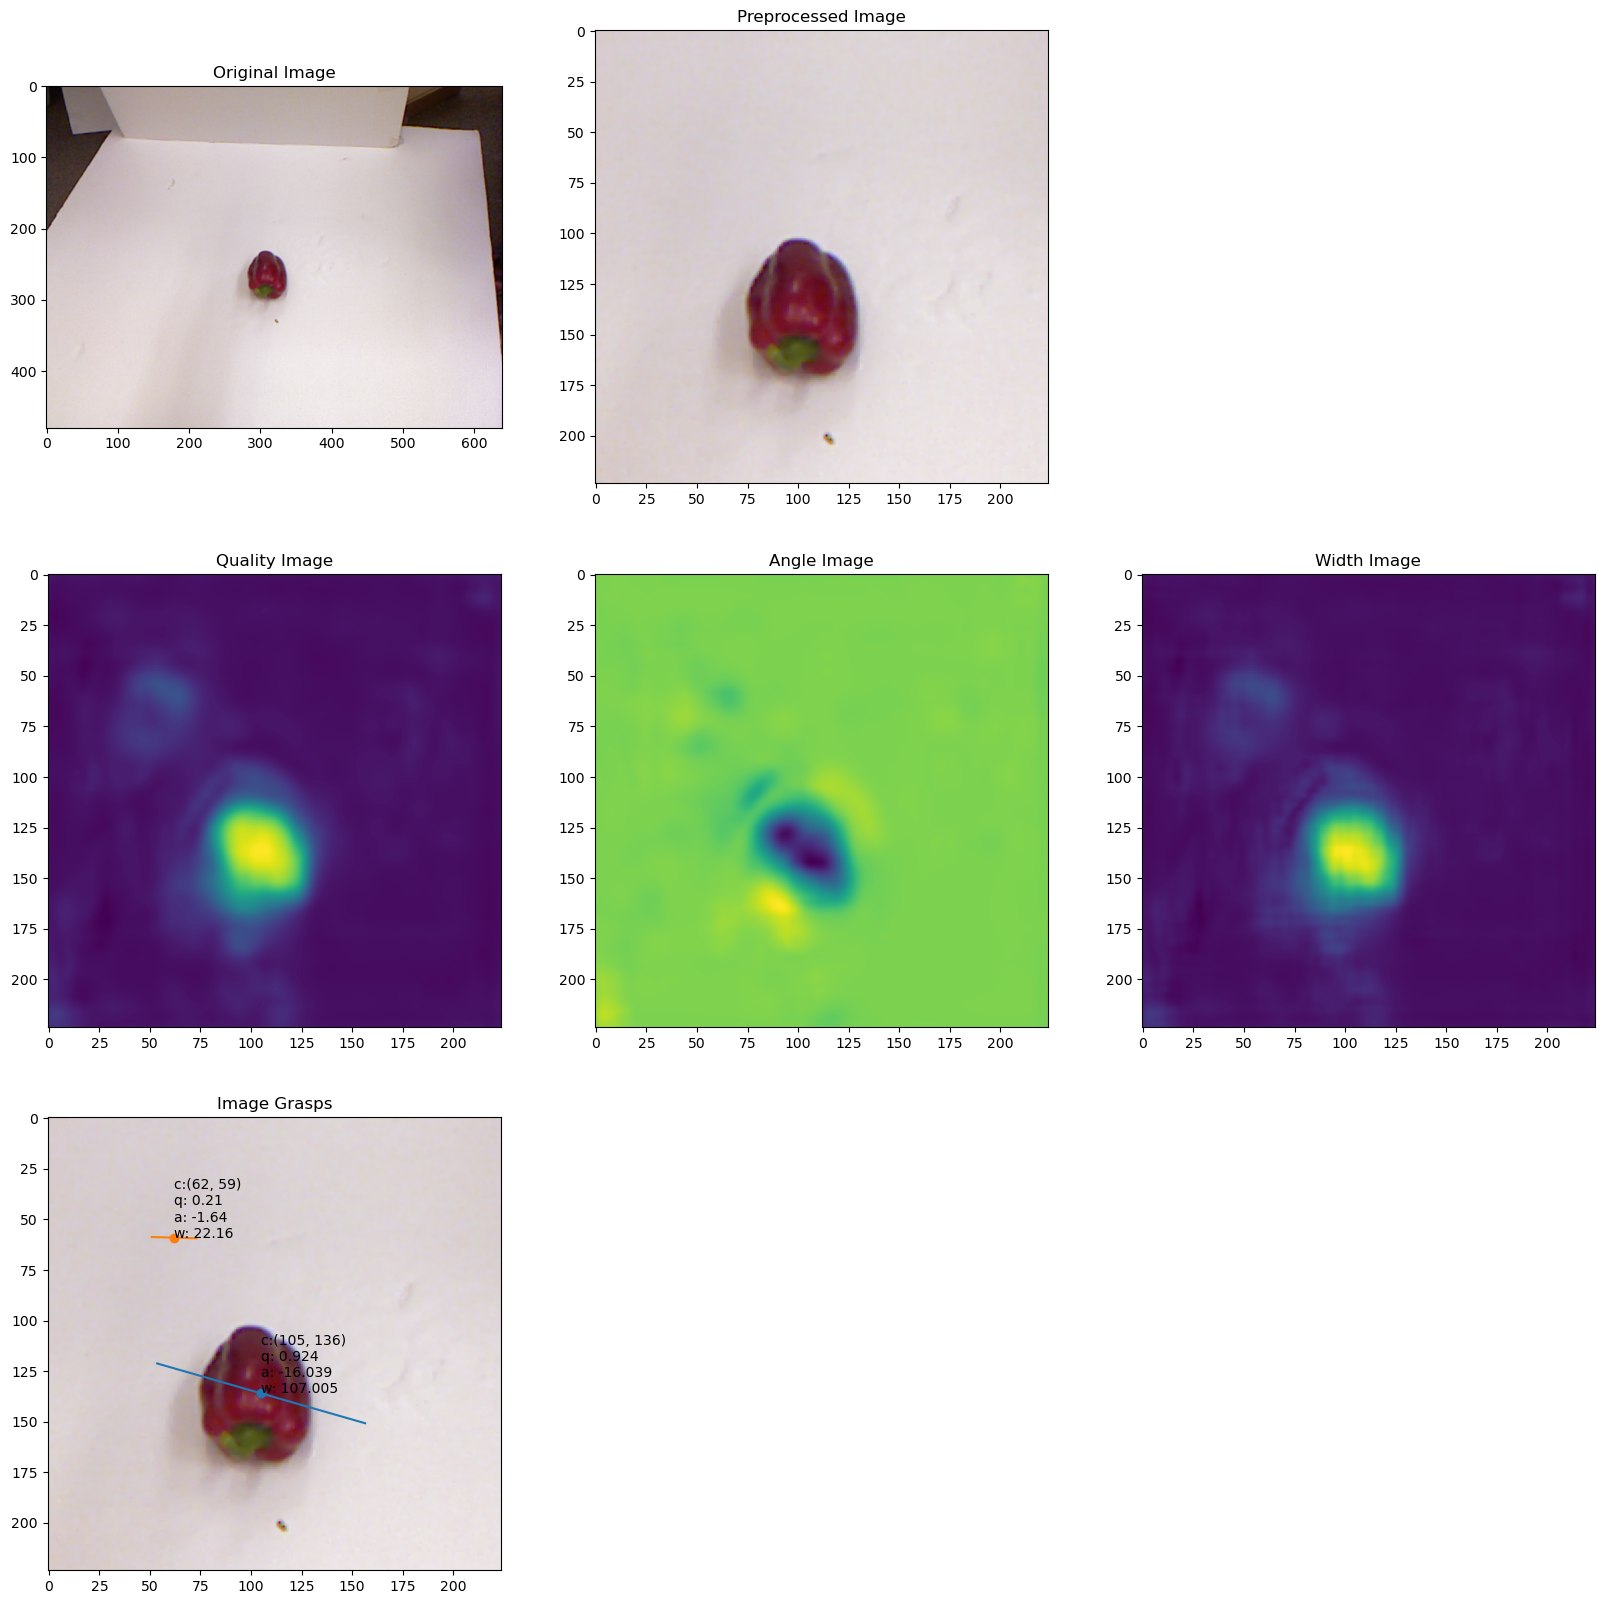

In [6]:
fig = vis.overview_fig(
    fig=plt.figure(figsize=(20,20)),
    original_rgb=vis.make_tensor_displayable(dataset.transform.intermediate_results["initial_sample"].rgb, True, True),
    preprocessed_rgb=vis.make_tensor_displayable(dataset.transform.intermediate_results["rgb_masked"], True, True),
    q_img=vis.make_tensor_displayable(postprocessor.intermediate_results["q_img"], False, False),
    angle_img=vis.make_tensor_displayable(postprocessor.intermediate_results["angle_img"], False, False),
    width_img=vis.make_tensor_displayable(postprocessor.intermediate_results["width_img"], False, False),
    image_grasps=grasps_img,
)

plt.show()